In [10]:
import os
import pickle
import sys
from argparse import ArgumentParser

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils.data import DataLoader
from torchvision import transforms

from utils import NUM_PTS, CROP_SIZE
from utils import ScaleMinSideToSize, CropCenter, TransformByKeys
from utils import ThousandLandmarksDataset
from utils import restore_landmarks_batch, create_submission

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from train import *

train_transforms = transforms.Compose([
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),
        LandmarksAugmentation(90),
    ])
path = "."
batch_size = 256
print("Reading data...")
train_dataset = ThousandLandmarksDataset(os.path.join(path, "train"), train_transforms, split="train")
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, pin_memory=True,
                                  shuffle=True, drop_last=True)
val_dataset = ThousandLandmarksDataset(os.path.join(path, "train"), train_transforms, split="val")
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, pin_memory=True,
                                shuffle=False, drop_last=False)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


print("Creating model...")
model = models.resnet101(pretrained=True, progress=False)
model.requires_grad_(False)

model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)
model.fc.requires_grad_(True)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
loss_fn = fnn.mse_loss


name = './runs/resnet101_ep37_loss2.877.pth'
with open(f"{name}", "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

for param in model.layer3.parameters():
    param.requires_grad = True
        #
        # train only head
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True
        #
        # train layer4
for param in model.layer4.parameters():
    param.requires_grad = True
    
trainer = Trainer(model, train_dataloader, val_dataloader)

trainer.start(5, 38)

Reading data...


100%|██████████| 60009/60009 [00:08<00:00, 6786.16it/s]  


Creating model...


training...:   0%|          | 0/187 [00:00<?, ?it/s]

Ready for training...


validation...: 100%|██████████| 47/47 [00:52<00:00,  1.12s/it]


Epoch #38:	train loss:   25.26	val loss:   10.15


validation...: 100%|██████████| 47/47 [00:27<00:00,  1.69it/s]


Epoch #39:	train loss:   12.94	val loss:   9.571


validation...: 100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


Epoch #40:	train loss:   11.63	val loss:   8.535


validation...: 100%|██████████| 47/47 [00:22<00:00,  2.06it/s]


Epoch #41:	train loss:   10.04	val loss:   8.353


validation...: 100%|██████████| 47/47 [00:22<00:00,  2.08it/s]


Epoch #42:	train loss:   8.545	val loss:   6.853


43

In [2]:
for param in model.parameters():
    param.requires_grad = True

In [12]:
trainer.start(5, 48)

training...:   0%|          | 0/187 [00:00<?, ?it/s]

Ready for training...


validation...: 100%|██████████| 47/47 [00:22<00:00,  2.10it/s]


Epoch #48:	train loss:    5.76	val loss:   5.123


training...:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch #49:	train loss:   5.654	val loss:   5.615
EarlyStopping counter: 1 out of 5


validation...: 100%|██████████| 47/47 [00:22<00:00,  2.09it/s]


Epoch #50:	train loss:    5.39	val loss:   5.089


training...:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch #51:	train loss:   5.196	val loss:   6.332
EarlyStopping counter: 1 out of 5


validation...: 100%|██████████| 47/47 [00:22<00:00,  2.08it/s]

Epoch #52:	train loss:   5.275	val loss:   6.971
EarlyStopping counter: 2 out of 5


53

In [9]:
import torchvision.transforms.functional as TF

class LandmarksAugmentation:
    def __init__(self, rotation_limit):
        self.rotation_limit = rotation_limit

    def random_rotation(self, image, landmarks):

        angle = np.random.uniform(-self.rotation_limit, self.rotation_limit)
        image = TF.rotate(image, angle)

        landmarks = landmarks.reshape(-1, 2)
        landmarks = torch.hstack((landmarks, torch.ones((landmarks.shape[0], 1))))
        center = (CROP_SIZE / 2, CROP_SIZE / 2)
        rad = angle * np.pi / 180.0
        alpha = np.cos(rad)
        beta = np.sin(rad)
        M_torch = torch.tensor([[alpha, beta, (1-alpha)*center[0] - beta*center[1]],
                                [-beta, alpha, beta*center[0] + (1-alpha)*center[1]]], dtype=torch.float32)
        new_landmark = torch.matmul(landmarks, M_torch.T)

        return image, new_landmark
    
    def __call__(self, sample):
        image, landmarks = self.random_rotation(sample['image'], sample['landmarks'])
        sample['image'] = image
        sample['landmarks'] = landmarks.flatten()
        return sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

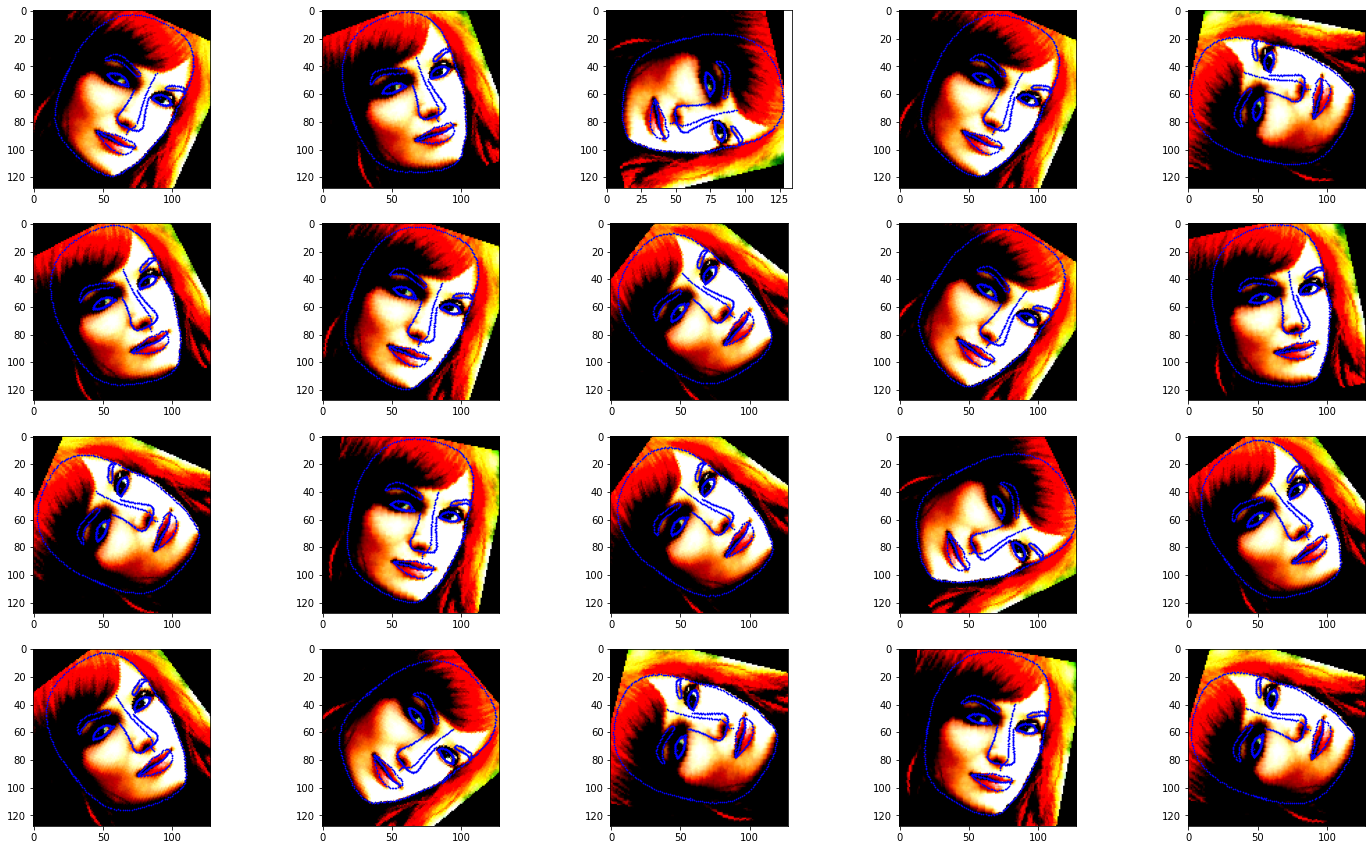

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 5, figsize=(25, 15))
idx = 0

for i in range(4):
    for j in range(5):
        aug = LandmarksAugmentation(90)
        augmented = aug(train_dataset[idx])
        image = augmented['image']
        landmarks = augmented['landmarks'].reshape(-1, 2)
        axes[i][j].imshow(image.permute(1, 2, 0))
        axes[i][j].scatter(landmarks[:, 0], landmarks[:, 1], color='blue', s=0.5)

## ничего

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Apr 29 21:30:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P0    26W /  70W |   2668MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## dataload

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Apr 28 12:37:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   24C    P8     9W /  70W |      7MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## resnet load

In [12]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Apr 28 12:40:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   31C    P0    26W /  70W |   3228MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
torch.cuda.empty_cache()

In [14]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Apr 28 12:41:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   29C    P0    26W /  70W |   1596MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Apr 28 12:41:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   29C    P0    26W /  70W |   1596MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Apr 28 13:07:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   28C    P0    26W /  70W |   6259MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------